In [1]:
# Importing libraries

import pandas as pd 
import numpy as num
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_boston
import copy 
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet
from scipy import stats
import datetime

In [2]:
# Uploading data

df1 = pd.read_csv(r'B:\results.csv', sep=';')
df2 = pd.read_csv(r'B:\User_id.csv')
df3 = pd.read_excel(r'B:\Mobidot\export-1641679263.xlsx')

C:\Users\jeanm\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
df1['date'] = df1['trip_time'].apply(lambda x: datetime.datetime.strptime(x + '00', "%Y-%m-%d %H:%M:%S%z"))

In [4]:
import datetime
df1['date'] = pd.to_datetime(df1['date'], errors='coerce', utc = True)
df1['day'] = df1.date.dt.strftime('%a')
df1['month'] = df1.date.dt.strftime('%B')
df1['hour'] = df1.date.dt.strftime('%H')
df1['date_1'] = df1.date.dt.strftime('%x')
user_id = []
for i in df1.user_id.unique():
    user = df1[df1.user_id == i].date_1.unique()
    if len(user) < 85:
        user_id.append(i)
df1 = df1[df1.user_id.isin(user_id) == False] 

In [5]:
df1 = df1[((df1['trip_objective'] == 'Shopping') | (df1['trip_objective'] == 'RoundTrip')) & ((df1['destination_type'] == 'supermarket') & (df1['destination_country'] == 'Nederland'))]
df1 = df1[df1.journey_desttype == 'supermarket']
df1['velocity'] = (df1['trip_distance'] / 1000) / (df1['trip_duration'] / 3600)

In [6]:
# Function to add two consecutive shopping times (Assumption: data is recorded twice, however, it is same trip)

def add_shopping_time(data_set):
    added_time = []
    index = []
    index_to_delete = []
    for i in range(len(data_set) - 1):
        if (data_set['trip_modality'][data_set.index[i]] == 'Stay' and data_set['trip_modality'][data_set.index[i+1]] == 'Stay') and (data_set.index[i] == data_set.index[i+1]):
            trip_duration = data_set['trip_duration'][data_set.index[i]] + data_set['trip_duration'][data_set.index[i+1]]
            data_set['trip_duration'][data_set.index[i]] = trip_duration
            index_to_delete.append(data_set.index[i+1])
        else: 
            if data_set['trip_modality'][data_set.index[i]] == 'Stay' and data_set['trip_modality'][data_set.index[i+1]] == 'Stay':
                index_to_delete.append(data_set.index[i+1])
    data_set = data_set.drop(index = index_to_delete)
    data_set['shopping_time'] = 0
    return data_set

In [7]:
# Funtion to add shopping time per trip

def shopping_time(data_set):
    shopping_times = []
    index = []
    for i in range(len(data_set)-1):
        if data_set['trip_modality'][data_set.index[i]] != 'Stay' and data_set['trip_modality'][data_set.index[i+1]] == 'Stay':
            data_set['shopping_time'][data_set.index[i]] = data_set['trip_duration'][data_set.index[i+1]]
        else:
            data_set['shopping_time'][data_set.index[i]] = np.nan

    data_set = data_set[data_set.trip_modality != 'Stay'] 
    data_set = data_set[data_set.trip_modality != 'Stay@office'] 

    return data_set

In [8]:
# Funtion to merge datasets 

def merge_data(dataset_1, dataset_2, dataset_3):
    dataset = dataset_1.reset_index().merge(dataset_2, how="left").set_index('index')
    user = dataset.reset_index().merge(dataset_3, left_on="tracker_id", right_on='ID', how="left").set_index('index')
    user = user.drop_duplicates()
    user = user.drop(['distance', 'home_duration', 'tracker_id', 'ID'], axis = 1)
    return user

In [9]:
# Translating variable names to english

def translation(data_set):
    return data_set.rename(columns = {'Leeftijd':'Age', 'Geslacht':'Gender', 'Stedelijkheid':'City_density', 'Gezinscyclus (kort)':'House_composition', 'Opleiding voltooid':'Education_level',
                              'Werkzaamheid':'Profession', 'Autobezit':'Car_ownership', 'Grootte huishouden':'Household_size', 'Bruto jaarinkomen huishouden (kort)':'Anual_income', 'Rijbewijsbezit':'Driving_license'})
    

In [10]:
df1 = add_shopping_time(df1)
df1 = shopping_time(df1)

C:\Users\jeanm\AppData\Local\Temp\ipykernel_3020\1775266528.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set['shopping_time'][data_set.index[i]] = data_set['trip_duration'][data_set.index[i+1]]
C:\Users\jeanm\AppData\Local\Temp\ipykernel_3020\1775266528.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set['shopping_time'][data_set.index[i]] = np.nan


In [11]:
data = pd.DataFrame()

In [12]:
# Record inconsistent trips
inconsistent = pd.DataFrame()
inconsistent = inconsistent.append(df1[df1['shopping_time'] > 5400])
inconsistent = inconsistent.append(df1[df1['velocity'] > 150])
inconsistent = inconsistent.append(df1[df1['trip_duration'] > 15000])
inconsistent = inconsistent.drop_duplicates()

C:\Users\jeanm\AppData\Local\Temp\ipykernel_3020\1608947751.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  inconsistent = inconsistent.append(df1[df1['shopping_time'] > 5400])
C:\Users\jeanm\AppData\Local\Temp\ipykernel_3020\1608947751.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  inconsistent = inconsistent.append(df1[df1['velocity'] > 150])
C:\Users\jeanm\AppData\Local\Temp\ipykernel_3020\1608947751.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  inconsistent = inconsistent.append(df1[df1['trip_duration'] > 15000])


In [13]:
df = df1.drop(index = inconsistent.index)
df = df.dropna(subset = ['shopping_time'])

In [14]:
df.shape

(52092, 35)

In [15]:
for j in df.user_id.unique():
    frame = df[df.user_id == j]
    for k in frame.trip_modality.unique():
        frame_1 = frame[frame.trip_modality == k]
        frame_1['num_trips'] = len(frame_1)
        result = frame_1.sample()
        data = data.append(result)    

C:\Users\jeanm\AppData\Local\Temp\ipykernel_3020\2294640953.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(result)
C:\Users\jeanm\AppData\Local\Temp\ipykernel_3020\2294640953.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_1['num_trips'] = len(frame_1)
C:\Users\jeanm\AppData\Local\Temp\ipykernel_3020\2294640953.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(result)
C:\Users\jeanm\AppData\Local\Temp\ipykernel_3020\2294640953.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [16]:
df.user_id.unique()

array([ 1135,  1180,  1195, ..., 53262, 53281, 53295], dtype=int64)

In [17]:
data.tail()

trip_id  user_id               trip_time trip_type trip_modality  \
5294745  12054059970    53262  2022-05-15 15:16:44+02   EnRoute          Bike   
5297836  11912508933    53281  2022-05-07 16:04:55+02   EnRoute           Car   
5297681  11760157402    53281  2022-04-29 16:19:32+02   EnRoute          Bike   
5300933  11404440211    53295  2022-04-09 09:41:18+02   EnRoute           Car   
5300937  11404480591    53295  2022-04-09 10:34:10+02   EnRoute          Foot   

         trip_distance chain_type         chain_objective trip_objective  \
5294745           1900  home-home                 Unknown       Shopping   
5297836           3200  home-home  PickUpOrDropOffPersons       Shopping   
5297681           1200  home-home                Shopping       Shopping   
5300933           6800  home-home                Shopping       Shopping   
5300937            350  home-home                Shopping       Shopping   

        journey_type  ... destination_longitude  stay_place_id  \
5294745      journey  ...              4.261096            NaN   
5297836      journey  ...              4.679263            NaN   
5297681      journey  ...              4.653919            NaN   
5300933      journey  ...              4.290309            NaN   
5300937      journey  ...              4.290309            NaN   

                             date  day  month  hour    date_1   velocity  \
5294745 2022-05-15 13:16:44+00:00  Sun    May    13  05/15/22  14.869565   
5297836 2022-05-07 14:04:55+00:00  Sat    May    14  05/07/22  19.232053   
5297681 2022-04-29 14:19:32+00:00  Fri  April    14  04/29/22   6.575342   
5300933 2022-04-09 07:41:18+00:00  Sat  April    07  04/09/22  21.896243   
5300937 2022-04-09 08:34:10+00:00  Sat  April    08  04/09/22   7.368421   

         shopping_time num_trips  
5294745          110.0         3  
5297836          334.0        48  
5297681          178.0         4  
5300933          685.0         5  
5300937         1078.0         1  

[5 rows x 36 columns]

In [18]:
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())


In [19]:
data['trip_distance_1'] = min_max_scaling(df['trip_distance'])
data['trip_duration_1'] = min_max_scaling(df['trip_duration'])
data['velocity_1'] = min_max_scaling(df['velocity'])
data['shopping_time_1'] = min_max_scaling(df['shopping_time'])

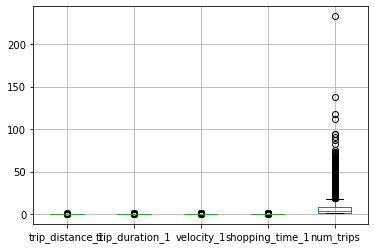

In [20]:
boxplot = data.boxplot(column=['trip_distance_1', 'trip_duration_1', 'velocity_1', 'shopping_time_1', 'num_trips'])  


In [21]:
df = merge_data(data, df2, df3)


In [22]:
df = translation(df)

In [23]:
df.head()

trip_id  user_id               trip_time trip_type trip_modality  \
index                                                                         
854    11240948941     1135  2022-03-29 09:41:11+02   EnRoute           Car   
1626   11133702222     1180  2022-03-22 13:16:04+01   EnRoute           Car   
1578   11041912247     1180  2022-03-16 11:15:55+01   EnRoute          Bike   
2134   12173644437     1180  2022-05-22 11:35:25+02   EnRoute          Foot   
2281   10914419948     1195  2022-03-07 18:06:10+01   EnRoute           Car   

       trip_distance chain_type chain_objective trip_objective journey_type  \
index                                                                         
854             3300  home-home        Shopping       Shopping      journey   
1626            4200  home-home        Shopping       Shopping      journey   
1578            1700  home-home    DailyCommute       Shopping      journey   
2134            2100  home-home        Shopping       Shopping      journey   
2281            3200  home-home           Sport       Shopping      journey   

       ...   Age  Gender  City_density House_composition Education_level  \
index  ...                                                                 
854    ...  78.0     1.0           4.0               2.0             6.0   
1626   ...  49.0     2.0           3.0              12.0             5.0   
1578   ...  49.0     2.0           3.0              12.0             5.0   
2134   ...  49.0     2.0           3.0              12.0             5.0   
2281   ...  37.0     1.0           2.0              11.0             2.0   

       Profession Car_ownership Household_size  Anual_income Driving_license  
index                                                                         
854           6.0           1.0            2.0           3.0             1.0  
1626          2.0           0.0            4.0           6.0             0.0  
1578          2.0           0.0            4.0           6.0             0.0  
2134          2.0           0.0            4.0           6.0             0.0  
2281          3.0           0.0            5.0           5.0             0.0  

[5 rows x 51 columns]

In [24]:
df['Gender'] = df['Gender'].replace([1, 2],['Male','Female'])
df['City_density'] = df['City_density'].replace([1.0, 2.0, 3.0, 4.0, 5.0],['Max_density','High_density', 'Medium_density', 'Low_density', 'Minimal_density'])
df['Education_level'] = df['Education_level'].replace([1, 2, 3, 4, 5, 6, 7, 8],['Primary_school_only','Lower_secondary_education'
                        , 'Medium_secondary_education', 'Medium_tertiary_education', 'Higher_secondary_education', 'Bachelor_education', 'Master_or_Doctoral',
                            'Unknow'])
df['Profession'] = df['Profession'].replace([1, 2, 3, 4, 5, 6, 7, 8, 9],['Entrepreneur','Employed', 'Governmental',
                        'Incapacitated', 'Unemployed', 'Retired', 'Studying', 'At_home', 'Unknow'])
df['House_composition'] = df['House_composition'].replace([0, 1, 2, 11, 12],['Unknown','Single', 'Adult_household',
                                'With_young_children', 'With_adolescent_children'])

df['Car_ownership'] = df['Car_ownership'].replace([1, 2, 0],['Yes','No', 'Unknwon'])
df['Anual_income'] = df['Anual_income'].replace([1, 2, 3, 5, 6, 7, 9],['Minimum','Lower_than_modal', 'Modal', 'One_to_two_times_modal',
                            'Two_times_modal', 'Higher_than_two_times_modal', 'Unkwnown'])
df['Driving_license'] = df['Car_ownership'].replace([1, 2, 0],['Yes','No', 'Unknwon'])

<AxesSubplot:xlabel='day', ylabel='count'>

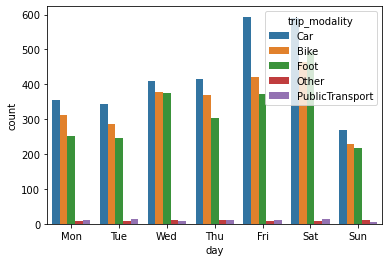

In [25]:
sns.countplot(x = 'day', data = df, order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], hue = 'trip_modality')

<AxesSubplot:xlabel='day', ylabel='count'>

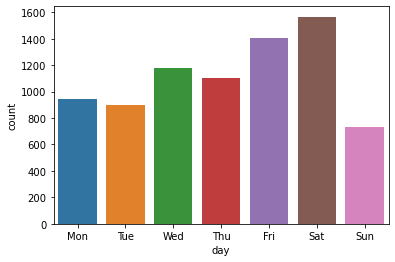

In [26]:
sns.countplot(x = 'day', data = df, order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

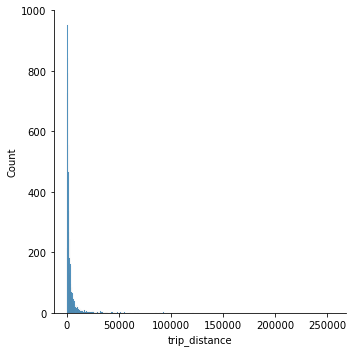

In [27]:
sns.displot(df['trip_distance'], kde = False)
#cut at 50, 000

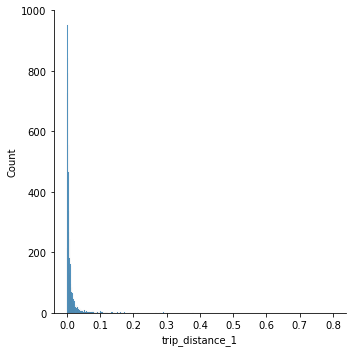

In [28]:
sns.displot(df['trip_distance_1'], kde = False)
#cut at 50, 000

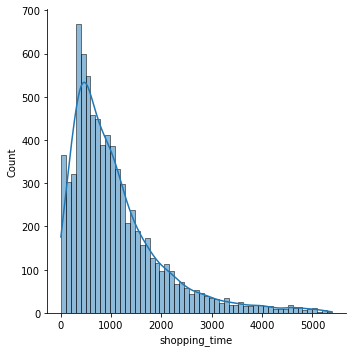

In [29]:
sns.displot(df['shopping_time'], kde = True)

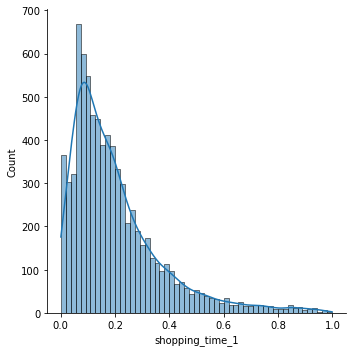

In [30]:
sns.displot(df['shopping_time_1'], kde = True)

In [31]:
x = list(df.Education_level.unique())

<AxesSubplot:xlabel='hour', ylabel='trip_distance_1'>

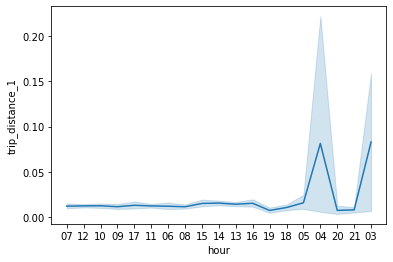

In [32]:
sns.lineplot(x = 'hour', y = 'trip_distance_1', data = df)

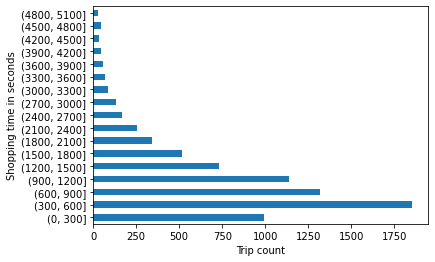

In [33]:
df.shopping_time.groupby(pd.cut(df.shopping_time, np.arange(0,5400,300))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Shopping time in seconds')
plt.show()

In [34]:
df.shopping_time.describe()

count    7824.000000
mean     1084.182004
std       912.788396
min         6.000000
25%       444.000000
50%       839.500000
75%      1425.250000
max      5389.000000
Name: shopping_time, dtype: float64

<AxesSubplot:xlabel='trip_distance', ylabel='num_trips'>

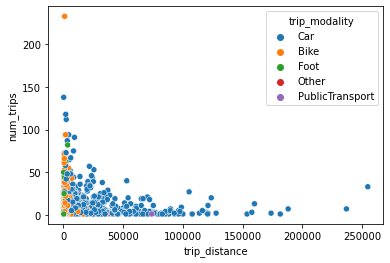

In [35]:
sns.scatterplot(x = "trip_distance", y = 'num_trips', data = df, hue = 'trip_modality')

In [36]:
df[df.num_trips > 100]

trip_id  user_id               trip_time trip_type trip_modality  \
index                                                                           
1615729  11055915578    31980  2022-03-17 10:34:53+01   EnRoute           Car   
1802619  12240001382    33557  2022-05-26 09:13:35+02   EnRoute          Bike   
1800098  11115907660    33557  2022-03-21 09:57:58+01   EnRoute           Car   
2555497  10970672601    38914  2022-03-11 14:30:52+01   EnRoute           Car   

         trip_distance chain_type chain_objective trip_objective journey_type  \
index                                                                           
1615729           2400  home-home        Shopping       Shopping      journey   
1802619           1100  home-home        Shopping       Shopping      journey   
1800098            280  home-home        Shopping       Shopping      journey   
2555497           2000  home-home        Shopping       Shopping      journey   

         ...   Age  Gender    City_density         House_composition  \
index    ...                                                           
1615729  ...  64.0    Male  Medium_density           Adult_household   
1802619  ...  60.0    Male  Medium_density  With_adolescent_children   
1800098  ...  60.0    Male  Medium_density  With_adolescent_children   
2555497  ...  42.0    Male     Max_density  With_adolescent_children   

                    Education_level  Profession Car_ownership Household_size  \
index                                                                          
1615729  Medium_secondary_education    Employed           Yes            2.0   
1802619   Medium_tertiary_education    Employed       Unknwon            5.0   
1800098   Medium_tertiary_education    Employed       Unknwon            5.0   
2555497          Master_or_Doctoral    Employed       Unknwon            3.0   

                   Anual_income Driving_license  
index                                            
1615729  One_to_two_times_modal             Yes  
1802619  One_to_two_times_modal         Unknwon  
1800098  One_to_two_times_modal         Unknwon  
2555497  One_to_two_times_modal         Unknwon  

[4 rows x 51 columns]

In [37]:
df = df[df.num_trips < 150]

<AxesSubplot:xlabel='trip_distance', ylabel='num_trips'>

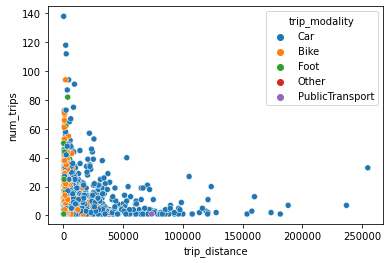

In [38]:
sns.scatterplot(x = "trip_distance", y = 'num_trips', data = df, hue = 'trip_modality')

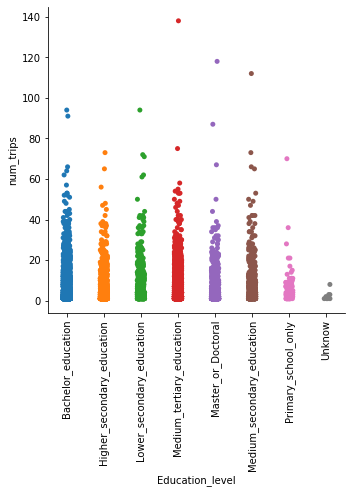

In [39]:
ax = sns.catplot(y = "num_trips", x = 'Education_level', data = df, kind = 'strip')
ax.set_xticklabels(rotation=90)


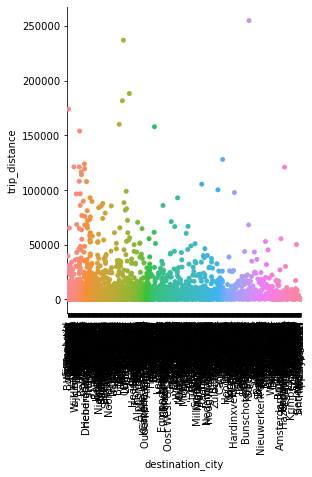

In [40]:
ax = sns.catplot(y = "trip_distance", x = 'destination_city', data = df, kind = 'strip')
ax.set_xticklabels(rotation=90)


In [118]:
df.columns

Index(['trip_id', 'user_id', 'trip_time', 'trip_type', 'trip_modality',
       'trip_distance', 'chain_type', 'chain_objective', 'trip_objective',
       'journey_type', 'journey_desttype', 'chain_id', 'journey_id',
       'journey_time0', 'journey_time1', 'journey_dist', 'journey_objective',
       'journey_source', 'stay_overnight_id', 'stay_overnight_type',
       'trip_duration', 'destination_osm_id', 'destination_type',
       'destination_country', 'destination_city', 'destination_latitude',
       'destination_longitude', 'stay_place_id', 'date', 'day', 'month',
       'hour', 'date_1', 'velocity', 'shopping_time', 'num_trips',
       'trip_distance_1', 'trip_duration_1', 'velocity_1', 'shopping_time_1',
       'Postcode 4', 'Age', 'Gender', 'City_density', 'House_composition',
       'Education_level', 'Profession', 'Car_ownership', 'Household_size',
       'Anual_income', 'Driving_license'],
      dtype='object')

C:\Users\jeanm\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trip_distance', ylabel='Density'>

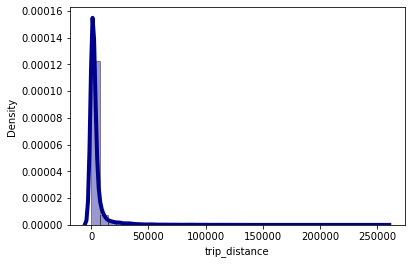

In [41]:
sns.distplot(df['trip_distance'], hist = True, kde=True, bins=35, color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})

C:\Users\jeanm\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='num_trips', ylabel='Density'>

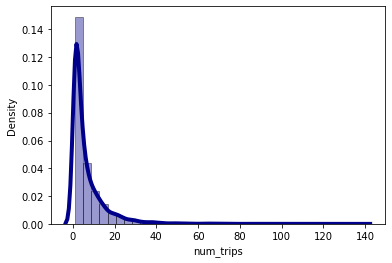

In [42]:
sns.distplot(df['num_trips'], hist = True, kde=True, bins=35, color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})

Text(0.5, 1.0, 'Side-by-Side Histogram with Gender')

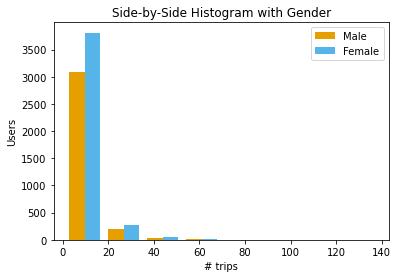

In [43]:
# Make a separate list for each airline
x1 = list(df[df['Gender'] == 'Male']['num_trips'])
x2 = list(df[df['Gender'] == 'Female']['num_trips'])

# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9']
names = ['Male', 'Female']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2], bins = 8,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('# trips')
plt.ylabel('Users')
plt.title('Side-by-Side Histogram with Gender')

In [45]:
df['date'] = df['date'].dt.tz_localize(None)


In [46]:
df.to_excel('last_data.xlsx')

In [47]:
df.columns

Index(['trip_id', 'user_id', 'trip_time', 'trip_type', 'trip_modality',
       'trip_distance', 'chain_type', 'chain_objective', 'trip_objective',
       'journey_type', 'journey_desttype', 'chain_id', 'journey_id',
       'journey_time0', 'journey_time1', 'journey_dist', 'journey_objective',
       'journey_source', 'stay_overnight_id', 'stay_overnight_type',
       'trip_duration', 'destination_osm_id', 'destination_type',
       'destination_country', 'destination_city', 'destination_latitude',
       'destination_longitude', 'stay_place_id', 'date', 'day', 'month',
       'hour', 'date_1', 'velocity', 'shopping_time', 'num_trips',
       'trip_distance_1', 'trip_duration_1', 'velocity_1', 'shopping_time_1',
       'Postcode 4', 'Age', 'Gender', 'City_density', 'House_composition',
       'Education_level', 'Profession', 'Car_ownership', 'Household_size',
       'Anual_income', 'Driving_license'],
      dtype='object')

(0.0, 5000.0)

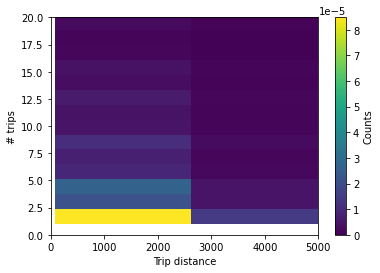

In [66]:
plt.hist2d(df.trip_distance, df.num_trips, bins=100, density = True)
plt.xlabel('Trip distance')
plt.ylabel('# trips')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts')
plt.ylim(0, 20)
plt.xlim(0, 5000)

<AxesSubplot:xlabel='num_trips', ylabel='Density'>

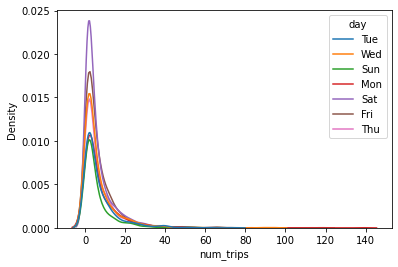

<AxesSubplot:xlabel='date', ylabel='Density'>

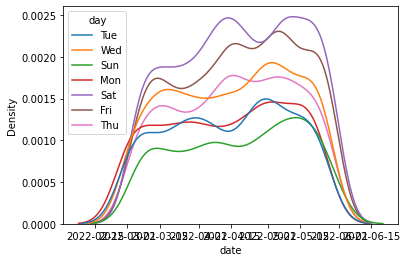

In [82]:
sns.kdeplot(data=df[df.num_trips < 40], x="date", hue="day")


<AxesSubplot:xlabel='num_trips', ylabel='Density'>

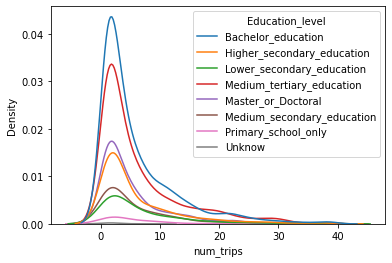

In [86]:
sns.kdeplot(data=df[df.num_trips < 40], x="num_trips", hue="Education_level", common_norm = True)


<AxesSubplot:xlabel='num_trips', ylabel='Density'>

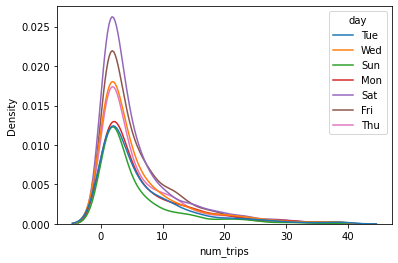

In [89]:
sns.kdeplot(data=df[df.num_trips < 40], x="num_trips", hue="day", common_norm = True)


<AxesSubplot:xlabel='num_trips', ylabel='Density'>

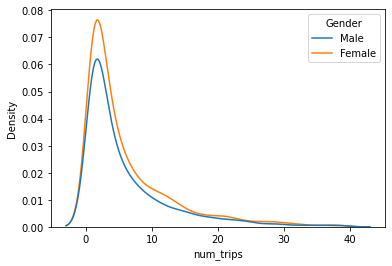

In [94]:
sns.kdeplot(data=df[df.num_trips < 40], x="num_trips", hue="Gender", common_norm = True)


In [92]:
df.columns

Index(['trip_id', 'user_id', 'trip_time', 'trip_type', 'trip_modality',
       'trip_distance', 'chain_type', 'chain_objective', 'trip_objective',
       'journey_type', 'journey_desttype', 'chain_id', 'journey_id',
       'journey_time0', 'journey_time1', 'journey_dist', 'journey_objective',
       'journey_source', 'stay_overnight_id', 'stay_overnight_type',
       'trip_duration', 'destination_osm_id', 'destination_type',
       'destination_country', 'destination_city', 'destination_latitude',
       'destination_longitude', 'stay_place_id', 'date', 'day', 'month',
       'hour', 'date_1', 'velocity', 'shopping_time', 'num_trips',
       'trip_distance_1', 'trip_duration_1', 'velocity_1', 'shopping_time_1',
       'Postcode 4', 'Age', 'Gender', 'City_density', 'House_composition',
       'Education_level', 'Profession', 'Car_ownership', 'Household_size',
       'Anual_income', 'Driving_license', 'num_trips_1'],
      dtype='object')

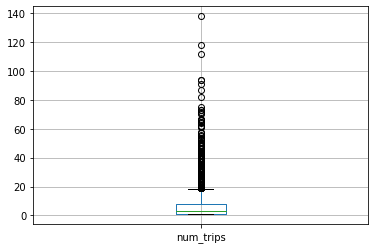

In [59]:
boxplot = df.boxplot(column=['num_trips'])  


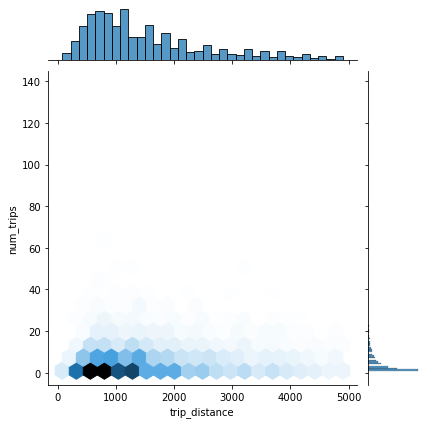

In [67]:
sns.jointplot(x='trip_distance',y='num_trips',data=df[df['trip_distance']<5000],kind='hex',gridsize=20)

In [75]:
example = df

In [96]:
example['num_trips_1'] = example['num_trips'] / 3

In [97]:
example.head(25)

trip_id  user_id               trip_time trip_type trip_modality  \
index                                                                         
854    11240948941     1135  2022-03-29 09:41:11+02   EnRoute           Car   
1626   11133702222     1180  2022-03-22 13:16:04+01   EnRoute           Car   
1578   11041912247     1180  2022-03-16 11:15:55+01   EnRoute          Bike   
2134   12173644437     1180  2022-05-22 11:35:25+02   EnRoute          Foot   
2281   10914419948     1195  2022-03-07 18:06:10+01   EnRoute           Car   
2412   11195623228     1195  2022-03-26 12:02:53+01   EnRoute          Foot   
2875   12096967612     1195  2022-05-18 08:21:27+02   EnRoute          Bike   
3613   11903023771     1212  2022-05-07 09:59:53+02   EnRoute           Car   
3292   11358215420     1212  2022-04-06 10:47:37+02   EnRoute          Foot   
3885   11077982340     1217  2022-03-18 16:46:39+01   EnRoute           Car   
5424   10858874056     1267  2022-03-04 11:04:26+01   EnRoute           Car   
5831   11653112397     1267  2022-04-23 16:04:56+02   EnRoute          Bike   
6566   11684105471     1269  2022-04-25 14:29:13+02   EnRoute          Bike   
6387   11356414027     1269  2022-04-06 09:09:04+02   EnRoute           Car   
6729   12211559051     1269  2022-05-24 15:21:20+02   EnRoute          Foot   
7676   12013164046     1325  2022-05-13 11:32:36+02   EnRoute          Bike   
7504   11754444314     1325  2022-04-29 12:04:19+02   EnRoute           Car   
7775   12170217034     1325  2022-05-22 10:19:53+02   EnRoute          Foot   
8403   11912368122     1365  2022-05-07 15:38:21+02   EnRoute          Bike   
8593   12282749667     1365  2022-05-28 12:19:08+02   EnRoute           Car   
8678   10924384975     1418  2022-03-08 13:58:10+01   EnRoute          Foot   
8946   11392722861     1418  2022-04-08 13:45:42+02   EnRoute           Car   
8999   11473697180     1418  2022-04-13 13:29:45+02   EnRoute          Bike   
10051  10942616286     1429  2022-03-09 16:39:46+01   EnRoute           Car   
11511  11405463362     1446  2022-04-09 11:28:20+02   EnRoute          Bike   

       trip_distance           chain_type chain_objective trip_objective  \
index                                                                      
854             3300            home-home        Shopping       Shopping   
1626            4200            home-home        Shopping       Shopping   
1578            1700            home-home    DailyCommute       Shopping   
2134            2100            home-home        Shopping       Shopping   
2281            3200            home-home           Sport       Shopping   
2412             400            home-home        Shopping       Shopping   
2875             520            home-home        Shopping       Shopping   
3613            2400            home-home        Shopping       Shopping   
3292             460            home-home        Shopping       Shopping   
3885            4600            home-home        Shopping       Shopping   
5424            1600            home-home        Shopping       Shopping   
5831             870            home-home        Shopping       Shopping   
6566            2200            home-home        Shopping       Shopping   
6387             770            home-home        Shopping       Shopping   
6729            1600            home-home        Shopping       Shopping   
7676           13100            home-home    DailyCommute       Shopping   
7504           10500            home-home        Visiting       Shopping   
7775             780            home-home        Shopping       Shopping   
8403            1100            home-home    DailyCommute       Shopping   
8593            5100            home-home        Shopping       Shopping   
8678            2500            home-home        Shopping       Shopping   
8946            2300  overnight-overnight        Shopping       Shopping   
8999            2400  overnight-overnight         Unk

In [98]:
CUT AT 60 KM

SyntaxError: invalid syntax (3081979697.py, line 1)